In [1]:
import GPy
import itertools  # Import the itertools module
import numpy as np
import math
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize,fmin_l_bfgs_b
from scipy.spatial import ConvexHull, Voronoi
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm, gaussian_kde

from skopt import BayesSearchCV
from skopt.space import Real

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# Guide and Ideas for Capstone Project - Function 2

# Function 2: Optimising Noisy Models
This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might have a lot of local optima! You are trying to make the model’s log-likelihood as large as possible.

<a id = 'Index:'></a>

# Table of Content

In this notebook you will apply xxxxxxx


- [Part 1](#part1)- Load the data
- [Part 1.1](#part11)- Voronoi
- [Part 2](#part2)- Optimisation
- [Part 4](#part4)- End

[Back to top](#Index:) 

<a id='part1'></a>

# Part 1 - Load the data & perform analysis

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_2/initial_inputs.npy')
Y = np.load('initial_data/function_2/initial_outputs.npy')
X2 = np.load('initial_data2/function_2/initial_inputs.npy')
Y2 = np.load('initial_data2/function_2/initial_outputs.npy')

X = np.vstack((X, X2))
Y = np.append(Y, Y2)

In [3]:
# Reshape Y2 if necessary to ensure it's a 2D array with a single column
#Y2_reshaped = Y2.reshape(-1, 1)

# Concatenate X2 and Y2 along the second axis (columns) to form a three-column array
#combined_array = np.hstack((X2, Y2_reshaped))

# Save the combined array to a text file, with values separated by spaces
#np.savetxt('f2_initial_data2.csv', combined_array, fmt='%.18f', delimiter=' ')

In [4]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [5]:
def print_timestamp():
    # Print out the timestamp
    print("Current Timestamp: ", datetime.now())

In [6]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,18))

0.6657995800131589-0.1239691276753491
0.8777909889953304-0.7786275008473289
0.1426990742359461-0.3490051305732002
0.8452754286767249-0.7111202665952655
0.4546471410512442-0.2904551797740609
0.5777128444074784-0.7719731841154063
0.4381660616117107-0.6850182567997548
0.3417495930288503-0.0286977198222779
0.3386481568870177-0.2138672456386437
0.7026365569244406-0.9265641975455574
0.3316259364531835-0.0804991069932658
0.1005327923748280-0.4775952374785060
0.6779321612385384-0.8737035505670930
0.1349558439995218-0.5211576695018724
0.5371556703199600-0.2447145898824138
0.6591284019847312-0.6306415647629386
0.4704520717882832-0.5337682542051888
0.7212023932444677-0.3645064412894298
0.7227338005571111-0.4380182227982026
0.2406676122610577-0.1412290743954429
--------------------------------------------------
0.538996118926918122-0.420586239627982639--0.065623624437337380-0.293992912410866003-0.214964510100450895-0.023105549798190586-0.244619344004480349-0.038749015156158403--0.01385761814972982

In [7]:
import plotly.io as pio

def plot_parallel_coordinates(dataframe, target,  chart_title='Parallel Coordinates Plot'):
    """
    Creates a parallel coordinates plot with the given DataFrame.

    Parameters:
    - dataframe: A pandas DataFrame containing the data to plot.
    - target: A string denoting the column name in the DataFrame to be used for color scaling.
    - chart_title: the title of the chart
    Returns:
    - A plotly Figure object containing the parallel coordinates plot.
    """
    # Check if the color column exists in the DataFrame
    if target not in dataframe.columns:
        raise ValueError(f"The color column '{target}' does not exist in the DataFrame.")

    # Determine the range for the color scale based on the 'y' values
    y_min = dataframe['y'].min()
    y_max = dataframe['y'].max()
    y_max_ceiling = math.ceil(y_max)
    
    # Generate more tick values. For example, create 5 evenly spaced ticks between y_min and y_max_ceiling.
    num_ticks = 5
    tick_vals = np.linspace(y_min, y_max_ceiling, num_ticks)

    fig = px.parallel_coordinates(dataframe, color="y", 
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             range_color=[y_min, y_max_ceiling])

    # Update the layout with a title
    fig.update_layout(
        title=chart_title,
        margin=dict(t=100),  # Adjust top margin to make space for the title
        coloraxis_colorbar=dict(
        title="y",
        tickvals=tick_vals,
        ticktext=[f"{val:.2f}" for val in tick_vals]
        )
    )
    fig.show()
    print(dataframe.describe())
    


In [8]:
# load w1 data
pd_new = pd.read_csv("data/capstone_results.csv")
print(f"Number of lines in the file: {pd_new.shape[0]}")
print(pd_new.head())

Number of lines in the file: 384
   Week  Student  Fn        X1        X2        X3        X4  X5  X6  X7  X8  \
0     1      427   1  0.605439  0.664755       NaN       NaN NaN NaN NaN NaN   
1     1      427   2  0.929767  0.997474       NaN       NaN NaN NaN NaN NaN   
2     1      427   3  0.990000  0.990000  0.000000       NaN NaN NaN NaN NaN   
3     1      427   4  0.459180  0.459289  0.399209  0.408363 NaN NaN NaN NaN   
4     1      427   5  0.261839  0.845899  0.945459  0.906905 NaN NaN NaN NaN   

             Y  
0     0.007671  
1    -0.011315  
2    -0.146375  
3    -1.081020  
4  1630.468499  


In [9]:
pw_fn = pd_new[pd_new['Fn']==2]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.
print(f"Number of lines in the file: {pw_fn.shape[0]}")

X_new_points = pw_fn[['X1','X2']].dropna().values
Y_new_points = pw_fn['Y'].dropna().values
print(X_new_points)
print(Y_new_points)

Number of lines in the file: 48
[[9.29767e-01 9.97474e-01]
 [9.83984e-01 9.99998e-01]
 [6.97146e-01 2.25741e-01]
 [7.17172e-01 0.00000e+00]
 [7.97980e-01 9.69697e-01]
 [7.87878e-01 9.59595e-01]
 [7.84126e-01 9.61904e-01]
 [4.22222e-01 8.33333e-01]
 [5.00000e-01 5.00000e-01]
 [9.29293e-01 1.41414e-01]
 [7.10761e-01 9.30180e-01]
 [8.68686e-01 7.77777e-01]
 [2.50000e-01 8.00000e-01]
 [8.00000e-01 6.22063e-01]
 [6.05111e-01 3.67570e-01]
 [7.94141e-01 9.07550e-02]
 [4.34343e-01 5.05051e-01]
 [8.87427e-01 3.87866e-01]
 [4.28459e-01 4.45764e-01]
 [6.50000e-01 5.00000e-01]
 [6.26190e-01 5.00000e-01]
 [2.40629e-01 5.73209e-01]
 [8.58586e-01 2.92929e-01]
 [2.28170e-01 5.66932e-01]
 [5.75758e-01 4.44444e-01]
 [8.77790e-01 7.78627e-01]
 [5.47815e-01 9.23904e-01]
 [6.99792e-01 4.25208e-01]
 [1.27768e-01 1.17724e-01]
 [8.28283e-01 3.03030e-01]
 [5.01157e-01 5.05474e-01]
 [4.99990e-01 5.20000e-01]
 [5.05000e-02 9.99555e-01]
 [1.05554e-01 8.32910e-01]
 [4.99060e-01 5.00858e-01]
 [5.05051e-01 4.84848e-

In [10]:
#append w1 data to the end

X_updated = np.vstack((X, X_new_points))
Y_updated = np.append(Y, Y_new_points)
print(X_updated)
print(Y_updated)

[[6.65799580e-01 1.23969128e-01]
 [8.77790989e-01 7.78627501e-01]
 [1.42699074e-01 3.49005131e-01]
 [8.45275429e-01 7.11120267e-01]
 [4.54647141e-01 2.90455180e-01]
 [5.77712844e-01 7.71973184e-01]
 [4.38166062e-01 6.85018257e-01]
 [3.41749593e-01 2.86977198e-02]
 [3.38648157e-01 2.13867246e-01]
 [7.02636557e-01 9.26564198e-01]
 [3.31625936e-01 8.04991070e-02]
 [1.00532792e-01 4.77595237e-01]
 [6.77932161e-01 8.73703551e-01]
 [1.34955844e-01 5.21157670e-01]
 [5.37155670e-01 2.44714590e-01]
 [6.59128402e-01 6.30641565e-01]
 [4.70452072e-01 5.33768254e-01]
 [7.21202393e-01 3.64506441e-01]
 [7.22733801e-01 4.38018223e-01]
 [2.40667612e-01 1.41229074e-01]
 [9.29767000e-01 9.97474000e-01]
 [9.83984000e-01 9.99998000e-01]
 [6.97146000e-01 2.25741000e-01]
 [7.17172000e-01 0.00000000e+00]
 [7.97980000e-01 9.69697000e-01]
 [7.87878000e-01 9.59595000e-01]
 [7.84126000e-01 9.61904000e-01]
 [4.22222000e-01 8.33333000e-01]
 [5.00000000e-01 5.00000000e-01]
 [9.29293000e-01 1.41414000e-01]
 [7.107610

In [11]:
def get_weekly_data(fn_no, week_no, pd_new):
    # Define the number of dimensions for each function
    fn_dim = {1: 2, 2: 2, 3: 3, 4: 4, 5: 4, 6: 5, 7: 6, 8: 8}
    
    # Get the number of dimensions for the given function number
    num_dim = fn_dim.get(fn_no, 2)  # Default to 2 if not specified

    # Filter the DataFrame for the specific week and function
    pd_fn = pd_new[(pd_new['Fn'] == fn_no) & (pd_new['Week'] == week_no)]
    
    # Dynamically create a list of 'X' column names based on the number of dimensions
    x_columns = [f'X{i}' for i in range(1, num_dim + 1)]

    # Extract X and Y values, dropping any rows with missing data
    X_new_week = pd_fn[x_columns].dropna().values
    Y_new_week = pd_fn['Y'].dropna().values
    
    return X_new_week, Y_new_week


print(get_weekly_data(2,1,pd_new))
print("\n")
print(get_weekly_data(2,2,pd_new))

(array([[0.929767, 0.997474],
       [0.983984, 0.999998],
       [0.697146, 0.225741],
       [0.717172, 0.      ],
       [0.79798 , 0.969697],
       [0.787878, 0.959595],
       [0.784126, 0.961904]]), array([-0.01131529, -0.14394131,  0.62583516,  0.56884671,  0.03423863,
        0.03279024,  0.1745532 ]))


(array([[0.422222, 0.833333],
       [0.5     , 0.5     ],
       [0.929293, 0.141414],
       [0.710761, 0.93018 ],
       [0.868686, 0.777777],
       [0.25    , 0.8     ],
       [0.8     , 0.622063]]), array([-0.08835513,  0.91987169, -0.03249548,  0.5333473 ,  0.34675589,
        0.0255495 ,  0.06164111]))


## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [12]:
next_query = np.random.uniform(size = 2)
print(next_query)

[0.8706319 0.1986103]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

It is important when tackling problems to really think about the best strategy and to do some exploratory data analysis. Let's consider what we know about the problem:

1. From the hints, we expect two modes in the unknown function.

2. From the hints, we know that most of our queries should be zero!

3. The problem is two-dimensional.

4. The problem will have small length-scale (that is, we expect the modes to be very small)

From (3.) we can take advantage, and plot the initial data:

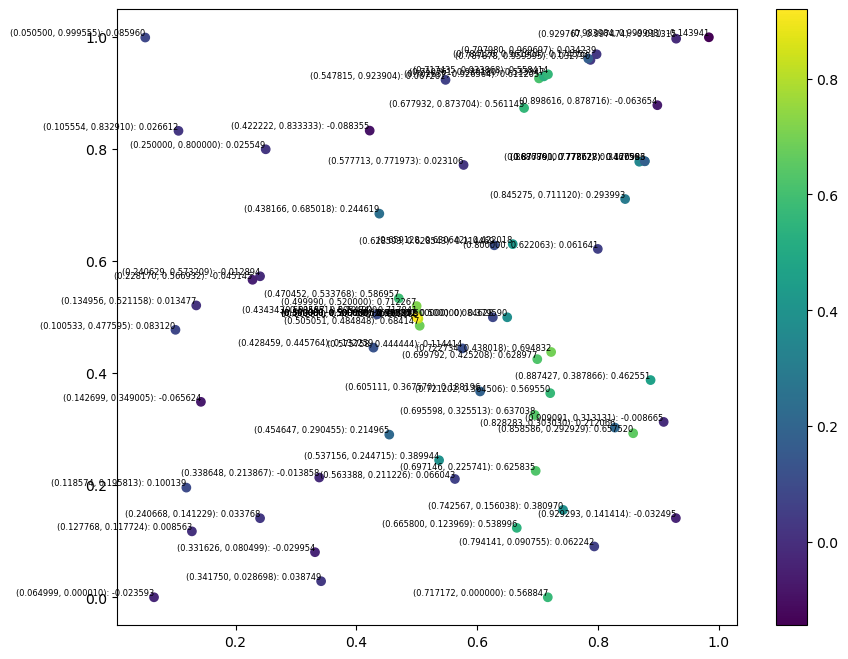

In [13]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)

# Scatter plot
scatter = ax.scatter(X_updated[:, 0], X_updated[:, 1], c=Y_updated)

# Adding a color bar
plt.colorbar(scatter)

# Looping over the data points to add labels with 16 digits of precision
for i in range(len(X_updated)):
    x_coord = f"{X_updated[i, 0]:.6f}"
    y_coord = f"{X_updated[i, 1]:.6f}"
    y_value = f"{Y_updated[i]:.6f}"
    label = f"({x_coord}, {y_coord}): {y_value}"
    ax.text(X_updated[i, 0], X_updated[i, 1], label, fontsize=6, ha='right', va='bottom')

plt.show()



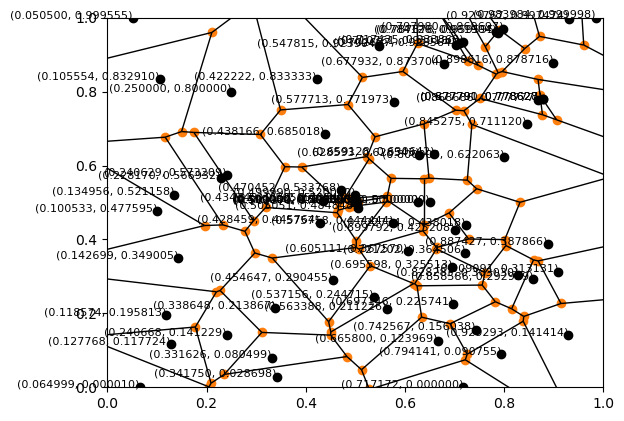

In [14]:
# create voroni diagram

from scipy.spatial import Voronoi, voronoi_plot_2d

# Your dataset points
points = X_updated

# Creating the Voronoi diagram
vor = Voronoi(points)

# Plotting the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=True)
ax.plot(points[:, 0], points[:, 1], 'ko')

# Annotating each point with its coordinates
for point in points:
    label = f'({point[0]:.6f}, {point[1]:.6f})'  # Format the label to two decimal places
    ax.text(point[0], point[1], label, fontsize=8, ha='right')


# Optionally, set the limits of the plot to ensure all annotations are visible
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.show()


[Back to top](#Index:) 

<a id='part11'></a>

## Part 1.1 - Voroni

## Maximum Empty Circle or MEC in a Voronoi diagram (convex)

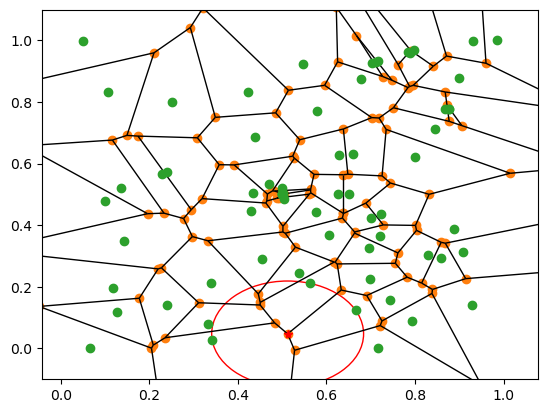

Center of the largest empty circle: 0.512256-0.047486
Radius of the largest empty circle: 0.17153828459260967
Current Timestamp:  2024-03-12 19:29:03.272737


In [15]:
from scipy.spatial import ConvexHull

# Compute Convex Hull
hull = ConvexHull(points)

# Function to check if a point is inside the convex hull
def in_hull(p, hull):
    if not isinstance(hull, ConvexHull):
        hull = ConvexHull(hull)
    return all((np.dot(eq[:-1], p) + eq[-1] <= 0) for eq in hull.equations)

# Find the largest empty circle
max_radius = 0
center_of_max_circle = None

for vertex in vor.vertices:
    if in_hull(vertex, hull):
        min_distance_to_point = min(np.linalg.norm(vertex - point) for point in points)
        if min_distance_to_point > max_radius:
            max_radius = min_distance_to_point
            center_of_max_circle = vertex

# Plotting for visualization
voronoi_plot_2d(vor)
plt.plot(points[:,0], points[:,1], 'o')
if center_of_max_circle is not None:
    plt.plot(center_of_max_circle[0], center_of_max_circle[1], '*r')
    circle = plt.Circle(center_of_max_circle, max_radius, color='r', fill=False)
    plt.gca().add_artist(circle)
plt.show()

if center_of_max_circle is not None:
    print("Center of the largest empty circle:", format_query(center_of_max_circle,6))
    print("Radius of the largest empty circle:", max_radius)
else:
    print("No empty circle found within the convex hull.")
    
print_timestamp()

## Maximum Empty Circle or MEC in a Voronoi diagram

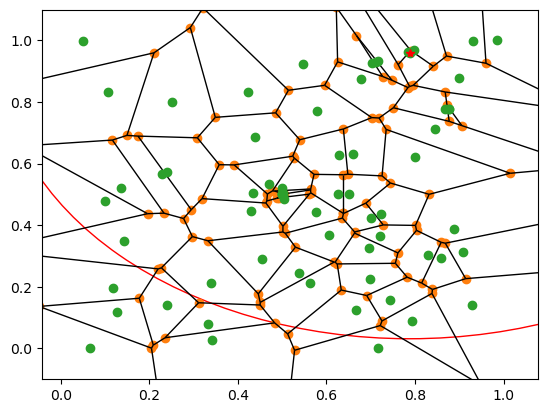

Center of the largest empty circle: 0.787878-0.959595
Radius of the largest empty circle: 0.9279844161812575
Current Timestamp:  2024-03-12 19:29:04.145124


In [16]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def largest_empty_circle(points):
    # Compute Voronoi diagram
    vor = Voronoi(points)
    
    # Iterate over Voronoi regions
    max_radius = 0
    best_point = None
    for point, region in zip(vor.points, vor.regions):
        if not region or -1 in region:
            continue

        # Compute the distances from the point to all edges of its Voronoi region
        region_points = np.asarray([vor.vertices[i] for i in region])
        distances = np.sqrt(((region_points - point) ** 2).sum(axis=1))

        # Find the maximum distance
        min_distance = np.min(distances)
        if min_distance > max_radius:
            max_radius = min_distance
            best_point = point

    return best_point, max_radius

# dataset points
points = X_updated
center, radius = largest_empty_circle(points)

# Plotting
voronoi_plot_2d(Voronoi(points))
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(center[0], center[1], '*r')
circle = plt.Circle(center, radius, color='r', fill=False)
plt.gca().add_patch(circle)
plt.show()

if center is not None:
    print("Center of the largest empty circle:", format_query(center,6))
    print("Radius of the largest empty circle:", radius)
else:
    print("No empty circle found.")

print_timestamp()

## The best point is [0.5, 0.5]

In [17]:
#Using a Kernel Density Estimate (KDE)
from scipy.stats import gaussian_kde

# existing 2D dataset
points = X_updated 

# Fit KDE to data
data_kde = gaussian_kde(points.T)

# Best point coordinates (can be expanded to more dimensions)
best_points = [0.5, 0.5] 

# Define the threshold for each dimension (assuming the same threshold for all dimensions)
threshold = 0.1  #  threshold value

# Calculate min and max values for each dimension based on the new threshold
min_values = [max(0, x - threshold) for x in best_points]
max_values = [min(1, x + threshold) for x in best_points]

# Increase the number of samples significantly
num_samples = 10000  # Try with a larger number of samples

# Sample new points from the KDE
kde_samples = data_kde.resample(size=num_samples)

# Filter the samples to only keep those within the defined region
conditions = [(kde_samples[i] >= min_values[i]) & (kde_samples[i] <= max_values[i]) for i in range(len(best_points))]
conditions += [(kde_samples[i] >= 0) & (kde_samples[i] <= 1) for i in range(len(best_points))]  # Ensure all dimensions are within [0, 1]
kde_samples_filtered = kde_samples[:, np.all(conditions, axis=0)].T  # Transpose the filtered samples


# Check if we have any points after filtering
if kde_samples_filtered.size == 0:
    raise ValueError("No points sampled within the specified region. Try increasing the number of samples or adjusting the region bounds.")

# Now kde_samples_filtered should contain new points sampled from the KDE within the specified region
#print(kde_samples_filtered.T)  # Transposed for easier readability


target_point = best_points

# Compute the Euclidean distances from each point in the dataset to the target point
distances = np.linalg.norm(kde_samples_filtered - target_point, axis=1)

# Get the indices of the 10 closest points
closest_indices = np.argsort(distances)[:10]

# Retrieve the closest points using these indices
closest_points = kde_samples_filtered[closest_indices]

print(f"The 10 closest points to {target_point} are:")
print(closest_points)

print_timestamp()

The 10 closest points to [0.5, 0.5] are:
[[0.50101763 0.50308774]
 [0.50431825 0.49682006]
 [0.49555291 0.49475382]
 [0.49494591 0.4917669 ]
 [0.51091872 0.50516485]
 [0.51135459 0.50476211]
 [0.49314812 0.48953154]
 [0.49122355 0.49085442]
 [0.51280806 0.49889387]
 [0.50035644 0.48697893]]
Current Timestamp:  2024-03-12 19:29:04.714938


In [18]:
# Assuming kde_samples_filtered is a numpy array
print(pd.DataFrame(kde_samples_filtered).describe())


                0           1
count  767.000000  767.000000
mean     0.507852    0.498146
std      0.056730    0.057394
min      0.400053    0.400642
25%      0.461681    0.447760
50%      0.510474    0.496820
75%      0.559482    0.545234
max      0.599906    0.599895


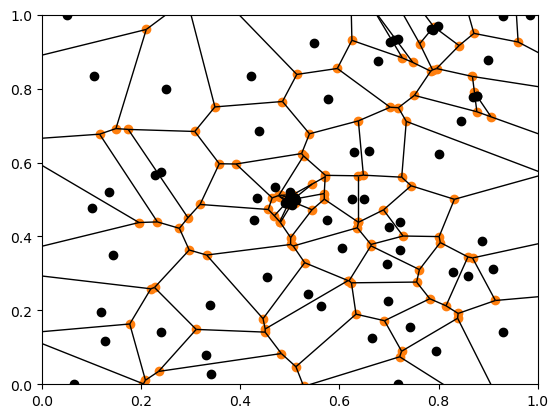

In [19]:
# Your dataset points
points = np.vstack((X_updated, closest_points))

# Creating the Voronoi diagram
vor = Voronoi(points)

# Plotting the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=True)
ax.plot(points[:, 0], points[:, 1], 'ko')

# Annotating each point with its coordinates
#for point in points:
 #   label = f'({point[0]:.6f}, {point[1]:.6f})'  # Format the label to two decimal places
  #  ax.text(point[0], point[1], label, fontsize=8, ha='right')


# Optionally, set the limits of the plot to ensure all annotations are visible
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.show()

In [20]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X_updated, columns=['x1', 'x2'])
df['y'] = Y_updated

In [44]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())

# Sort the DataFrame by 'y' in descending order and take the top 5
top_10 = df.sort_values(by='y', ascending=False).head(10)

# Print out the top 5 rows
print(top_10)

Statistical Summary:
              x1         x2          y
count  68.000000  68.000000  68.000000
mean    0.567262   0.516343   0.283611
std     0.251150   0.287940   0.300583
min     0.050500   0.000000  -0.143941
25%     0.432872   0.300505   0.031246
50%     0.591412   0.500000   0.175773
75%     0.752957   0.777990   0.563069
max     0.983984   0.999998   0.919872
          x1        x2         y
28  0.500000  0.500000  0.919872
65  0.500000  0.500000  0.915251
54  0.499060  0.500858  0.865711
57  0.502870  0.497493  0.832183
58  0.500000  0.500000  0.783361
50  0.501157  0.505474  0.717841
51  0.499990  0.520000  0.712267
18  0.722734  0.438018  0.694832
55  0.505051  0.484848  0.684147
42  0.858586  0.292929  0.657520


In [22]:

plot_parallel_coordinates(df, 'y', "F2 Parallel Coordinates Plot")
print_timestamp()

              x1         x2          y
count  68.000000  68.000000  68.000000
mean    0.567262   0.516343   0.283611
std     0.251150   0.287940   0.300583
min     0.050500   0.000000  -0.143941
25%     0.432872   0.300505   0.031246
50%     0.591412   0.500000   0.175773
75%     0.752957   0.777990   0.563069
max     0.983984   0.999998   0.919872
Current Timestamp:  2024-03-12 19:29:07.839406


[Back to top](#Index:) 

<a id='part2'></a>

### Part 2 - Optimisation

## Approach 1: Random Search

In [23]:
#Approach 1

# Random search around an area restricted around
# best points so far
# 0.66579958	0.123969128	0.538996119
# 0.702636557	0.926564198	0.611205216

delta = 0.05

# Given the best points are around 0.65, we want to center our search around this value
# and expand slightly beyond it to continue exploring.
domain_start_x1 = 0.4 - delta  # Now starts slightly below the best points
domain_end_x1 = 0.6 + delta    # Now ends slightly above the best points
domain_start_x2 = 0.3 - delta  
domain_end_x2 = 0.9 + delta      
print(f"domain_start_x1= {domain_start_x1} and domain_end_x1 = {domain_end_x1}")

next_query_x1 = np.random.normal(domain_start_x1, scale = 0.01)
next_query_x2 = np.random.normal(domain_end_x1, scale = 0.01)
print('Next query Random: ', [next_query_x1, next_query_x2])



domain_start_x1= 0.35000000000000003 and domain_end_x1 = 0.65
Next query Random:  [0.3434536148534687, 0.6410412806267356]


In [24]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)

print("Kappa Array:")
for index, value in enumerate(kappa_array):
    print(f"Week {index+1}(Index {index}): {value}")

print("Xi Array:")
for index, value in enumerate(xi_array):
    print(f"Week {index +1}(Index {index}): {value}")

Kappa Array:
Week 1(Index 0): 1.96
Week 2(Index 1): 1.764
Week 3(Index 2): 1.5876000000000001
Week 4(Index 3): 1.42884
Week 5(Index 4): 1.285956
Week 6(Index 5): 1.1573604000000002
Week 7(Index 6): 1.0416243600000001
Week 8(Index 7): 0.9374619240000002
Week 9(Index 8): 0.8437157316000001
Week 10(Index 9): 0.7593441584400001
Xi Array:
Week 1(Index 0): 0.1
Week 2(Index 1): 0.09000000000000001
Week 3(Index 2): 0.08100000000000002
Week 4(Index 3): 0.0729
Week 5(Index 4): 0.06561
Week 6(Index 5): 0.05904900000000001
Week 7(Index 6): 0.05314410000000001
Week 8(Index 7): 0.04782969000000001
Week 9(Index 8): 0.04304672100000001
Week 10(Index 9): 0.03874204890000001


In [25]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")

In [26]:
def predict_in_batches(model, X, batch_size=10000, return_std=False):
    y_pred = []
    y_std = []
    for i in range(0, len(X), batch_size):
        if return_std:
            batch_pred, batch_std = model.predict(X[i:i + batch_size], return_std=True)
            y_std.extend(batch_std)
        else:
            batch_pred = model.predict(X[i:i + batch_size])
        y_pred.extend(batch_pred)
    return (np.array(y_pred), np.array(y_std)) if return_std else np.array(y_pred)

def expected_improvement(X_grid, gp, xi=0.01, model_type='sklearn'):
    mu, sigma = predict_in_batches(gp, X_grid, return_std=True) if model_type == 'sklearn' else gp.predict(X_grid)
    mu_sample_opt = np.max(mu)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

def probability_of_improvement(X_grid, gp, xi=0.01, model_type='sklearn'):
    mu, sigma = predict_in_batches(gp, X_grid, return_std=True) if model_type == 'sklearn' else gp.predict(X_grid)
    mu_sample_opt = np.max(mu)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi

def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='sklearn'):
    mu, sigma = predict_in_batches(gp, X_grid, return_std=True) if model_type == 'sklearn' else gp.predict(X_grid)
    ucb = mu + kappa * sigma
    return ucb


In [27]:
# define grid based on dimensions

def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

def generate_nd_grid_hv(domain_bounds, num_points_per_dimension):
    """
    Generate an N-dimensional grid of points for optimization.

    Parameters:
    domain_bounds: A list of tuples, where each tuple contains the start and end values for one dimension.
    num_points_per_dimension: Number of points to generate in each dimension.

    Returns:
    X_grid: An N-dimensional numpy array of grid points.
    """
    
    # Create a list of arrays, each containing evenly spaced values for one dimension
    axis_values = [np.linspace(start, end, num_points_per_dimension) for start, end in domain_bounds]
    
    # Create the meshgrid for N dimensions and reshape it for model consumption
    X_grid_hv = np.array(np.meshgrid(*axis_values)).T.reshape(-1, len(domain_bounds))
    
    return X_grid_hv

# Example usage:
#domain_bounds = [(0.6, 0.65), (0.6, 0.65), (0.6, 0.65)]  # Let's say we have a 3D problem
#num_points_per_dimension = 100  # Number of points along each dimension
#X_grid = generate_nd_grid(domain_bounds, num_points_per_dimension)


In [28]:
# propose the next points for all three acquisition functions

def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb



# Approach 2 : using RandomSearch with Gaussian

In [ ]:
#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-4, 1e4), # expanded from 1e-3 to 1e3 to 1e-4 to 1e4,
    'kernel__k2__length_scale': loguniform(1e-5, 1e3) # expanded from 1e-4 to 1e2 to 1e-5 to 1e3.

}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=10, random_state=42, n_jobs=-1)
random_search.fit(X_updated,Y_updated)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points)

print_timestamp()

# Using GridSearch with Gaussian

Best Parameters: {'kernel': 31.6**2 * RationalQuadratic(alpha=10, length_scale=100) + WhiteKernel(noise_level=1)}
Log-marginal-likelihood: 11.323198262967033
MSE: 0.0019076709316890067
R-squared: 0.9808963192375719


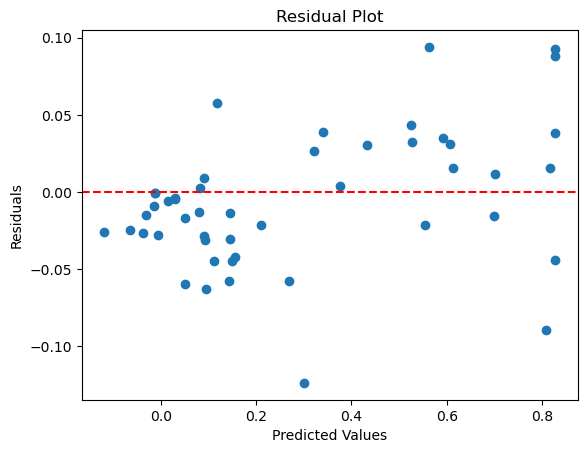

Current Timestamp:  2024-03-12 19:36:22.926126


In [29]:
#from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic, WhiteKernel
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV

# Define parameter grid with fixed values
param_grid = {
    'kernel': [
        C(constant_value) * RationalQuadratic(alpha=alpha, length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
        for constant_value in np.logspace(-3, 3, num=5)  # Example range for constant_value
        for alpha in np.logspace(-2, 1, num=5)          # Example range for alpha
        for length_scale in np.logspace(-2, 2, num=5)   # Example range for length_scale
        for noise_level in [1, 10, 100]                 # Example fixed values for noise_level
    ]
}

# Instantiate Gaussian Process Regressor
gp = GaussianProcessRegressor(n_restarts_optimizer=20)

grid_search = GridSearchCV(gp, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_updated, Y_updated)

# Retrieve the best model and parameters
best_gp = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points)

print_timestamp()

In [30]:
from joblib import dump

# Save the model to disk
dump(grid_search, 'f2_grid_search.joblib')

['f2_grid_search.joblib']

In [ ]:
# Retrieve the best model and parameters
best_gp = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points)

print_timestamp()

In [ ]:
# Utilised the best parameter trained from last week
# Define the kernel with the best parameters
optimal_kernel = C(1.0) * RationalQuadratic(alpha=0.0562, length_scale=10) + WhiteKernel(noise_level=10)

# Instantiate the Gaussian Process Regressor with the optimal kernel
gp_best = GaussianProcessRegressor(kernel=optimal_kernel, n_restarts_optimizer=20)

# Assuming X_updated and Y_updated are your training data
gp_best.fit(X_updated, Y_updated)

# Using BaySearch with Gaussian

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real

# Define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

# Create a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Define the search space for the hyperparameters
search_spaces = {
    'kernel__k1__constant_value': Real(1e-4, 1e4, prior='log-uniform'),
    'kernel__k2__length_scale': Real(1e-5, 1e3, prior='log-uniform')
    # You can also add 'k2__noise_level' if needed
}

# Instantiate BayesSearchCV
bayes_search = BayesSearchCV(gp, search_spaces, n_iter=10, cv=10, random_state=42, n_jobs=-1)

# Fit the model
bayes_search.fit(X_updated, Y_updated)

# Retrieve the best model and parameters
best_gp = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points)

print_timestamp()


## Approach 2 sklearn - alternative: train sequentially

In [ ]:
#Approach 2 - alternative
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
# Define your initial kernel and model
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Define hyperparameter search space
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-4, 1e3),
    'kernel__k2__length_scale': loguniform(1e-4, 1e2)
}

# Function to update model with new data and optimize hyperparameters
def update_and_optimize_model(gp, X_train, Y_train):
    # Update the model with new data
    gp.fit(X_train, Y_train)

    # Hyperparameter optimization
    random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, Y_train)

    # Best model and parameters
    best_gp = random_search.best_estimator_
    best_params = random_search.best_params_
    print("Best Parameters:", best_params)
    print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}") # Higher values typically indicate a better fit. can sometimes indicate overfitting
    
    return best_gp

# Initial training data
X_train = X # the initial X data
Y_train = Y # the initial Y data

# Initial model fitting and hyperparameter optimization
best_gp = update_and_optimize_model(gp, X_train, Y_train)

number_of_weeks =2 # this is the 3rd week, we have additional 2 weeks data

# Example usage for weekly updates
for week in range(number_of_weeks):
    print(f"week = {week}")
    # Assume X_new_week and Y_new_week are the new data you receive every week
    X_new_week, Y_new_week = get_weekly_data(2,week+1, pd_new)
    
    # Combine old training data with new data
    X_train = np.vstack((X_train, X_new_week))
    Y_train = np.hstack((Y_train, Y_new_week))

    # Update the model with new data and optimize hyperparameters
    best_gp = update_and_optimize_model(best_gp, X_train, Y_train)


In [ ]:
from joblib import load

# Load the model from disk
grid_search = load('f2_grid_search.joblib')
best_gp = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")
mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')

print_timestamp()   

## Appoach 2: using sklearn GP model via 2D grid

In [31]:
#Approach 2: using sklearn GP model via random generated grid

# best points so far: 
# 0.628540	0.628540	2.000000
# 0.650000	0.650000	0.195741
# to optimize the acquisition function, we will simply use gridsearch over a space of 10.000 gridpoints
#the NumPy library's linspace function to generate an array x1 evenly spaced numbers: start of 0.6; end of 0.65; 100 samples to generate
# Use numpy's meshgrid function to create a grid efficiently
num_points = 3000
X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 9  # For week 10, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

Next query EI:  0.496849-0.499283
Next query PI:  0.498449-0.499517
Next query UCB:  0.497749-0.499517
Current Timestamp:  2024-03-11 16:36:58.828010


global_optimum_prediction = [0.8274465]


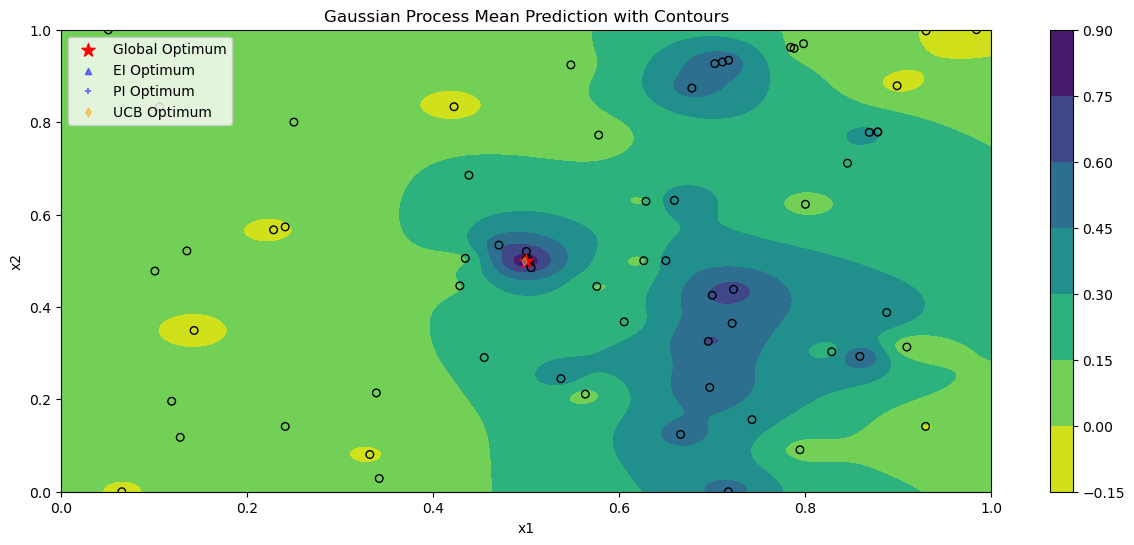

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


# Known global optimum
global_optimum_x = 0.500000000000
global_optimum_y = 0.500000000000
global_optimum_value = 0.919871693233

# Predict the value at the global optimum
global_optimum_prediction = best_gp.predict(np.array([[global_optimum_x, global_optimum_y]]))
print(f"global_optimum_prediction = {global_optimum_prediction}")

next_ei = best_gp.predict(next_point_ei.reshape(1, -1))
next_pi = best_gp.predict(next_point_pi.reshape(1, -1))
next_ucb = best_gp.predict(next_point_ucb.reshape(1, -1))

# Replace X_sample and Y_sample with your actual data
X_sample = X_updated[:, 0]  # This would be your x1 values from X_updated
Y_sample = X_updated[:, 1]  # This would be your x2 values from X_updated
Z_sample = Y_updated  # This would be your y values from Y_updated

# Define a higher-resolution grid over which we'll visualize the GP
x_contour = np.linspace(0, 1, 500)
y_contour = np.linspace(0, 1, 500)
X_grid_contour, Y_grid_contour = np.meshgrid(x_contour, y_contour)

# Interpolate Z values on this grid using griddata (cubic interpolation)
#Z_interpolated = griddata((X_sample, Y_sample), Z_sample, (X_grid_contour, Y_grid_contour), method='cubic')

# Assuming 'best_gp' is your trained Gaussian Process model
# Predict on the finer mesh grid
mu, std = best_gp.predict(np.stack((X_grid_contour.ravel(), Y_grid_contour.ravel()), axis=1), return_std=True)
mu = mu.reshape(X_grid_contour.shape)


# Set the figure size as a tuple (width, height) in inches
plt.figure(figsize=(15, 6))  # 12 inches wide by 6 inches tall

#plt.xlim(0.2, 0.9)
#plt.ylim(0.2, 0.9)

# Create filled contours
#contourf_plot = plt.contourf(X_grid_contour, Y_grid_contour, mu, levels=100, cmap='viridis', alpha=0.5)  # Increased number of levels for smoother color transitions
#contourf_plot = plt.contour(X_grid_contour, Y_grid_contour, mu, vmax=1.2, levels=100, cmap='viridis_r', alpha=0.5)  # Increased number of levels for smoother color transitions
contourf_plot = plt.contourf(X_grid_contour, Y_grid_contour, mu,cmap="viridis_r")


plt.colorbar(contourf_plot)


# Optionally, you can specify custom levels
#custom_levels = np.linspace(mu.min(), mu.max(), num=100)
custom_levels = np.linspace(-1, 5, num=20)
#contour_lines = plt.contour(X_grid_contour, Y_grid_contour, mu, levels=custom_levels, colors='white', linewidths=1)
#contour_lines = plt.contour(X_grid_contour, Y_grid_contour, mu, levels=50, colors='lightgrey', linewidths=1, alpha=0.5)
#plt.clabel(contour_lines, inline=True, fontsize=8)


# Plot actual data points
plt.scatter(X_sample, Y_sample, facecolors='none', s=30, edgecolor='k')
plt.scatter(global_optimum_x, global_optimum_y, color='red', marker='*', s=100, zorder=10, label='Global Optimum')
plt.scatter(next_point_ei[0], next_point_ei[1], color='blue', marker='^', s=20, zorder=10, label='EI Optimum', alpha = 0.5)
plt.scatter(next_point_pi[0], next_point_pi[1], color='blue', marker='+', s=20, zorder=10, label='PI Optimum', alpha = 0.5)
plt.scatter(next_point_ucb[0], next_point_ucb[1], color='orange', marker='d', s=20, zorder=10, label='UCB Optimum', alpha = 0.5)


# Optionally, you can overlay the interpolated data as a scatter plot to visualize the data density and distribution
#plt.scatter(X_grid_contour, Y_grid_contour, c=Z_interpolated, cmap='viridis_r', alpha=0.3)

plt.title('Gaussian Process Mean Prediction with Contours')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')

plt.show()

In [33]:
# Flatten mu to a 1D array
mu_flat = mu.ravel()

# Get indices of the largest 5 mu values
largest_mu_indices = np.argsort(mu_flat)[-5:]

# Use these indices to find corresponding X and Y coordinates
largest_X_coords = X_grid_contour.ravel()[largest_mu_indices]
largest_Y_coords = Y_grid_contour.ravel()[largest_mu_indices]

# Print results
print("Largest 5 mu values and their X, Y coordinates:")
for i in range(5):
    print(f"mu: {mu_flat[largest_mu_indices[i]]}, X: {largest_X_coords[i]}, Y: {largest_Y_coords[i]}")

Largest 5 mu values and their X, Y coordinates:
mu: 0.8247946933682754, X: 0.49699398797595185, Y: 0.501002004008016
mu: 0.8251101303349945, X: 0.49699398797595185, Y: 0.4989979959919839
mu: 0.8254880210905593, X: 0.501002004008016, Y: 0.4989979959919839
mu: 0.8270916837892703, X: 0.4989979959919839, Y: 0.501002004008016
mu: 0.8277206590656924, X: 0.4989979959919839, Y: 0.4989979959919839


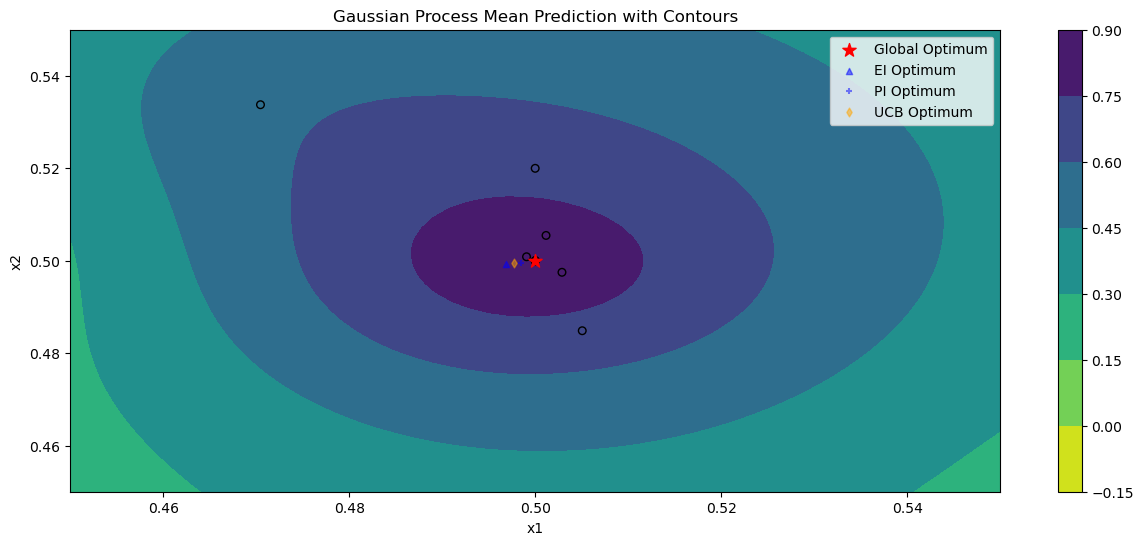

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


# Known global optimum
global_optimum_x = 0.500000000000
global_optimum_y = 0.500000000000
global_optimum_value = 0.919871693233

next_ei = best_gp.predict(next_point_ei.reshape(1, -1))
next_pi = best_gp.predict(next_point_pi.reshape(1, -1))
next_ucb = best_gp.predict(next_point_ucb.reshape(1, -1))

# Replace X_sample and Y_sample with your actual data
X_sample = X_updated[:, 0]  # This would be your x1 values from X_updated
Y_sample = X_updated[:, 1]  # This would be your x2 values from X_updated
Z_sample = Y_updated  # This would be your y values from Y_updated

# Define a higher-resolution grid over which we'll visualize the GP
x_contour = np.linspace(0, 1, 500)
y_contour = np.linspace(0, 1, 500)
X_grid_contour, Y_grid_contour = np.meshgrid(x_contour, y_contour)

# Interpolate Z values on this grid using griddata (cubic interpolation)
#Z_interpolated = griddata((X_sample, Y_sample), Z_sample, (X_grid_contour, Y_grid_contour), method='cubic')

# Assuming 'best_gp' is your trained Gaussian Process model
# Predict on the finer mesh grid
mu, std = best_gp.predict(np.stack((X_grid_contour.ravel(), Y_grid_contour.ravel()), axis=1), return_std=True)
mu = mu.reshape(X_grid_contour.shape)


# Set the figure size as a tuple (width, height) in inches
plt.figure(figsize=(15, 6))  # 12 inches wide by 6 inches tall

plt.xlim(0.45, 0.55)
plt.ylim(0.45, 0.55)

# Create filled contours
#contourf_plot = plt.contourf(X_grid_contour, Y_grid_contour, mu, levels=100, cmap='viridis', alpha=0.5)  # Increased number of levels for smoother color transitions
#contourf_plot = plt.contour(X_grid_contour, Y_grid_contour, mu, vmax=1.2, levels=100, cmap='viridis_r', alpha=0.5)  # Increased number of levels for smoother color transitions
contourf_plot = plt.contourf(X_grid_contour, Y_grid_contour, mu,cmap="viridis_r")


plt.colorbar(contourf_plot)


# Optionally, you can specify custom levels
#custom_levels = np.linspace(mu.min(), mu.max(), num=100)
custom_levels = np.linspace(-1, 5, num=20)
#contour_lines = plt.contour(X_grid_contour, Y_grid_contour, mu, levels=custom_levels, colors='white', linewidths=1)
#contour_lines = plt.contour(X_grid_contour, Y_grid_contour, mu, levels=50, colors='lightgrey', linewidths=1, alpha=0.5)
#plt.clabel(contour_lines, inline=True, fontsize=8)


# Plot actual data points
plt.scatter(X_sample, Y_sample, facecolors='none', s=30, edgecolor='k')
plt.scatter(global_optimum_x, global_optimum_y, color='red', marker='*', s=100, zorder=10, label='Global Optimum')
plt.scatter(next_point_ei[0], next_point_ei[1], color='blue', marker='^', s=20, zorder=10, label='EI Optimum', alpha = 0.5)
plt.scatter(next_point_pi[0], next_point_pi[1], color='blue', marker='+', s=20, zorder=10, label='PI Optimum', alpha = 0.5)
plt.scatter(next_point_ucb[0], next_point_ucb[1], color='orange', marker='d', s=20, zorder=10, label='UCB Optimum', alpha = 0.5)


# Optionally, you can overlay the interpolated data as a scatter plot to visualize the data density and distribution
#plt.scatter(X_grid_contour, Y_grid_contour, c=Z_interpolated, cmap='viridis_r', alpha=0.3)

plt.title('Gaussian Process Mean Prediction with Contours')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

plt.show()

# Exploitation in high value region [0.5, 	0.5, y=0.919871693233]

In [36]:
domain_bounds= [(0.499999, 0.599999), (0.499999, 0.599999)]
num_points_per_dimension = 3000  # Number of points along each dimension
X_grid_hv = generate_nd_grid_hv(domain_bounds, num_points_per_dimension)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 9  # For week 10, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid_hv,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

#print_timestamp()


y_highvalue_pred = predict_in_batches(best_gp, X_grid_hv)


# After evaluation, you can create a DataFrame for analysis
df_evaluation = pd.DataFrame(X_grid_hv, columns=['x1', 'x2'])
df_evaluation['y'] = y_highvalue_pred

# Sort the DataFrame by 'y' in descending order to get the largest values at the top
sorted_df_hv = df_evaluation.sort_values(by='y', ascending=False)

# Take the top n entries after sorting
n_samples = 500  # Adjust n to your preferred sample size
sampled_df_hv = sorted_df_hv.head(n_samples)
print(sampled_df_hv.head(20))

plot_parallel_coordinates(sampled_df_hv, 'y', "F2 Grid Search Results Parallel Coordinates Plot")
print_timestamp()
 


Next query EI:  0.499999-0.499999
Next query PI:  0.499999-0.499999
Next query UCB:  0.499999-0.499999
            x1        x2         y
0     0.499999  0.499999  0.827448
1     0.499999  0.500032  0.827435
2     0.499999  0.500066  0.827420
3000  0.500032  0.499999  0.827409
3     0.499999  0.500099  0.827404
3001  0.500032  0.500032  0.827395
4     0.499999  0.500132  0.827387
3002  0.500032  0.500066  0.827381
5     0.499999  0.500166  0.827368
6000  0.500066  0.499999  0.827368
3003  0.500032  0.500099  0.827365
6001  0.500066  0.500032  0.827354
6     0.499999  0.500199  0.827348
3004  0.500032  0.500132  0.827347
6002  0.500066  0.500066  0.827340
3005  0.500032  0.500166  0.827329
7     0.499999  0.500232  0.827327
9000  0.500099  0.499999  0.827326
6003  0.500066  0.500099  0.827324
9001  0.500099  0.500032  0.827312


               x1          x2           y
count  500.000000  500.000000  500.000000
mean     0.500272    0.500414    0.826753
std      0.000190    0.000283    0.000307
min      0.499999    0.499999    0.826278
25%      0.500099    0.500166    0.826490
50%      0.500249    0.500366    0.826720
75%      0.500432    0.500633    0.826994
max      0.500699    0.501099    0.827448
Current Timestamp:  2024-03-11 16:50:06.871232


In [34]:
def generate_sparse_grid(domain_bounds, points_per_dim):
    """Generate a sparse grid for high-dimensional spaces."""
    num_dims = len(domain_bounds)
    total_points = points_per_dim ** (1 / num_dims)
    axis_values = [np.linspace(start, end, int(np.ceil(total_points))) for start, end in domain_bounds]
    grid = np.meshgrid(*axis_values, indexing='ij')
    sparse_grid = np.vstack([x.ravel() for x in grid]).T
    return sparse_grid

# Example usage
#domain_bounds = [(0, 1), (0, 1), (0, 1)]  # 3D problem
#sparse_grid = generate_sparse_grid(domain_bounds, 1000)
#print("Sparse grid points:", sparse_grid.shape[0])


#domain_bounds= [(0.47, 0.53), (0.47, 0.53)]
domain_bounds= [(0.499999, 0.599999), (0.499999, 0.599999)]
num_points_per_dimension = 5000  # Number of points along each dimension
X_sparse_grid_hv = generate_sparse_grid(domain_bounds, num_points_per_dimension)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 8  # For week 9, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_sparse_grid_hv,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

#print_timestamp()


y_highvalue_pred = predict_in_batches(best_gp, X_sparse_grid_hv)


# After evaluation, you can create a DataFrame for analysis
df_evaluation = pd.DataFrame(X_sparse_grid_hv, columns=[f'x{i+1}' for i in range(len(domain_bounds))])
df_evaluation['y'] = y_highvalue_pred

# Sort the DataFrame by 'y' in descending order to get the smallest values at the top
sorted_df_hv = df_evaluation.sort_values(by='y', ascending=False)

# Take the top n entries after sorting
n_samples = 500  # Adjust n to your preferred sample size
sampled_df_hv = sorted_df_hv.head(n_samples)
print(sampled_df_hv.head(20))

plot_parallel_coordinates(sampled_df_hv, 'y', "F2 Sparse Search Results Parallel Coordinates Plot")
print_timestamp()

Next query EI:  0.499999-0.499999
Next query PI:  0.499999-0.499999
Next query UCB:  0.499999-0.499999
           x1        x2         y
0    0.499999  0.499999  0.827448
1    0.499999  0.501428  0.825696
71   0.501428  0.499999  0.824587
72   0.501428  0.501428  0.822771
2    0.499999  0.502856  0.821663
142  0.502856  0.499999  0.819407
73   0.501428  0.502856  0.818690
143  0.502856  0.501428  0.817589
3    0.499999  0.504285  0.815624
144  0.502856  0.502856  0.813546
74   0.501428  0.504285  0.812620
213  0.504285  0.499999  0.812072
214  0.504285  0.501428  0.810310
4    0.499999  0.505713  0.807909
145  0.502856  0.504285  0.807550
215  0.504285  0.502856  0.806386
75   0.501428  0.505713  0.804888
284  0.505713  0.499999  0.802798
285  0.505713  0.501428  0.801143
216  0.504285  0.504285  0.800562


               x1          x2           y
count  500.000000  500.000000  500.000000
mean     0.512696    0.516665    0.651522
std      0.008463    0.010880    0.073731
min      0.499999    0.499999    0.551809
25%      0.505713    0.507142    0.588603
50%      0.511428    0.515713    0.636213
75%      0.519999    0.525713    0.704196
max      0.529999    0.541428    0.827448
Current Timestamp:  2024-03-11 16:42:46.596397


In [35]:
from scipy.stats.qmc import Sobol

def sample_sobol_sequence(domain_bounds, num_samples):
    dim = len(domain_bounds)
    sobol_sampler = Sobol(d=dim, scramble=True)
    samples = sobol_sampler.random_base2(m=int(np.log2(num_samples)))
    # Rescale samples to the domain bounds
    rescaled_samples = np.array([start + (end - start) * samples[:, i] for i, (start, end) in enumerate(domain_bounds)]).T
    return rescaled_samples

# Example usage
#domain_bounds = [(0, 1), (0, 1), (0, 1)]  # 3D problem
#num_samples = 1000
#sobol_samples = sample_sobol_sequence(domain_bounds, num_samples)
#print("Sobol sequence samples:", sobol_samples.shape[0])

#domain_bounds= [(0.47, 0.53), (0.47, 0.53)]
domain_bounds= [(0.499999, 0.599999), (0.499999, 0.599999)]
num_points_per_dimension = 2048  # Number of points along each dimension
X_sobol_grid_hv = sample_sobol_sequence(domain_bounds, num_points_per_dimension)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 8  # For week 9, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_sobol_grid_hv,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

#print_timestamp()


y_highvalue_pred = predict_in_batches(best_gp, X_sobol_grid_hv, batch_size=10000)


# After evaluation, you can create a DataFrame for analysis
df_evaluation = pd.DataFrame(X_sobol_grid_hv, columns=[f'x{i+1}' for i in range(len(domain_bounds))])
df_evaluation['y'] = y_highvalue_pred

# Sort the DataFrame by 'y' in descending order to get the smallest values at the top
sorted_df_hv = df_evaluation.sort_values(by='y', ascending=False)

# Take the top n entries after sorting
n_samples = 500  # Adjust n to your preferred sample size
sampled_df_hv = sorted_df_hv.head(n_samples)
print(sampled_df_hv.head(20))

plot_parallel_coordinates(sampled_df_hv, 'y', "F2 Sobol Search Results Parallel Coordinates Plot")
print_timestamp()

Next query EI:  0.500076-0.501239
Next query PI:  0.500076-0.501239
Next query UCB:  0.500076-0.501239
            x1        x2         y
1555  0.500076  0.501239  0.825966
595   0.502525  0.502036  0.817516
1491  0.502269  0.504171  0.810422
403   0.501383  0.504963  0.809263
947   0.503506  0.503681  0.807318
115   0.505088  0.500364  0.806854
1075  0.504398  0.502718  0.806205
1875  0.502959  0.506410  0.795284
1795  0.507525  0.501905  0.786256
787   0.500717  0.508769  0.786095
131   0.506634  0.504482  0.784536
2035  0.505759  0.506041  0.782613
835   0.508205  0.501164  0.781779
307   0.504159  0.507682  0.781539
1171  0.500949  0.510125  0.775378
1395  0.505034  0.508471  0.771614
1315  0.509454  0.500476  0.771027
515   0.507275  0.506930  0.767225
1219  0.508877  0.505228  0.763507
1715  0.503561  0.511013  0.760103


               x1          x2           y
count  500.000000  500.000000  500.000000
mean     0.520508    0.527375    0.547572
std      0.012810    0.016890    0.097751
min      0.500021    0.500030    0.427827
25%      0.509477    0.513128    0.465104
50%      0.519522    0.526064    0.523017
75%      0.530830    0.540586    0.605200
max      0.546535    0.564239    0.825966
Current Timestamp:  2024-03-11 16:46:52.904972


## Appoach 2: using sklearn GP model via Voronoi diagram generated grid

In [37]:
# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 8  # For week 9, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,kde_samples_filtered,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

Next query EI:  0.498899-0.495615
Next query PI:  0.498899-0.495615
Next query UCB:  0.498899-0.495615
Current Timestamp:  2024-03-11 16:55:18.095946


## Aproach 3:  a Sparse Gaussian Process model

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |                value  |  constraints  |  priors
  variance     |  0.04630200532807142  |      +ve      |        
  lengthscale  |  0.34369968300404424  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                         0.05983795  |      +ve      |        
MSE on validation set: 0.12782358504105173
MSE: 0.06316018345950694
R-squared: 0.367505180446124


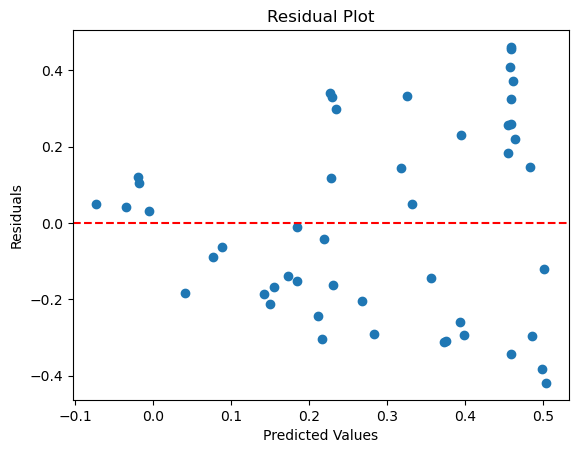

Current Timestamp:  2024-03-11 16:55:26.450493


In [38]:
# Approach 3: gpy GP model

# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y_w1 is 1D, convert it to 2D
if Y_updated.ndim == 1:
    Y_updated_2d = Y_updated[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_updated.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_updated, Y_updated_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_new_points)
mse = np.mean((Y_new_points - Y_pred)**2)
print("MSE on validation set:", mse)

mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')

print_timestamp()

In [39]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')


#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

Next query EI:  0.621390-0.467539
Next query PI:  0.620790-0.467773
Next query UCB:  0.620890-0.467773
Current Timestamp:  2024-03-11 16:55:54.666661


In [30]:
from scipy.optimize import minimize

global_optimum = np.array([0.5, 0.5])

# Define the range around the global optimum you want to explore
# This can be a percentage of the original range or a fixed value
# For example, explore within +/- 10% of each dimension around the optimum
exploit_range = 0.1  # 10%

# Calculate new bounds around the global optimum based on exploit_range
new_bounds = np.array([[opt - exploit_range, opt + exploit_range] for opt in global_optimum])

# Ensure new bounds do not exceed original bounds [0, 1]
new_bounds = np.clip(new_bounds, 0, 1)
					  
					  
# Function to propose the next sampling point by minimizing the GP's predicted mean
def propose_next_sample(gp, bounds):
    num_restarts = 1000  # Number of restarts in the optimization to avoid local minima
    samples_and_predictions = []  # List to store tuples of (sampled point, predicted value)  

    def gp_obj(X, gp):
        X_reshaped = np.atleast_2d(X)
        prediction = gp.predict(X_reshaped)[0]
        samples_and_predictions.append((X, prediction))  # Store point and prediction as a tuple
        return prediction

    best_x = None
    best_y = np.inf
    
    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], (num_restarts, bounds.shape[0])):
        res = minimize(gp_obj, x0=starting_point, bounds=bounds, args=(gp), method='L-BFGS-B')
        if res.fun < best_y:
            best_x = res.x
            best_y = res.fun

    # Sort the list of tuples by the predicted value in descending order
    samples_and_predictions.sort(key=lambda x: x[1], reverse=True)

    # Print the total number of sampled points
    print(f"Total number of sampled points: {len(samples_and_predictions)}")

    # Print the sampled points and their predicted values in descending order
    for point, value in samples_and_predictions:
        print(f"Sampled Point: {point}, Predicted Value: {value}")
    
    return best_x

# Use the propose_next_sample function to find new points to evaluate
next_sample = propose_next_sample(best_gp, new_bounds)
print(f"Proposed next sample for evaluation: {next_sample}")

Total number of sampled points: 41574
Sampled Point: [0.50137448 0.50092801], Predicted Value: 0.8238250339282273
Sampled Point: [0.50137448 0.50092802], Predicted Value: 0.8238250186745167
Sampled Point: [0.50137449 0.50092801], Predicted Value: 0.8238250060507498
Sampled Point: [0.49506604 0.50075015], Predicted Value: 0.8184598357251609
Sampled Point: [0.49506603 0.50075015], Predicted Value: 0.8184597906438403
Sampled Point: [0.49506603 0.50075016], Predicted Value: 0.8184597825922508
Sampled Point: [0.49865241 0.49585197], Predicted Value: 0.8184578141245297
Sampled Point: [0.49865242 0.49585196], Predicted Value: 0.818457771951375
Sampled Point: [0.49865241 0.49585196], Predicted Value: 0.8184577655084854
Sampled Point: [0.50239894 0.49734635], Predicted Value: 0.8181618221346835
Sampled Point: [0.50239894 0.49734634], Predicted Value: 0.8181617937660045
Sampled Point: [0.50239895 0.49734634], Predicted Value: 0.8181617554479588
Sampled Point: [0.50304962 0.50063291], Predicted V

Sampled Point: [0.43314311 0.6       ], Predicted Value: 0.250845251654683
Sampled Point: [0.4331431  0.59999999], Predicted Value: 0.2508452438735186
Sampled Point: [0.4331431 0.6      ], Predicted Value: 0.25084523522729374
Sampled Point: [0.54673362 0.44040388], Predicted Value: 0.25063460301027923
Sampled Point: [0.54673362 0.44040387], Predicted Value: 0.25063458562957536
Sampled Point: [0.54673363 0.44040387], Predicted Value: 0.2506345452499339
Sampled Point: [0.53308747 0.40834948], Predicted Value: 0.2506256584932832
Sampled Point: [0.53308747 0.40834947], Predicted Value: 0.2506256517022757
Sampled Point: [0.53308748 0.40834947], Predicted Value: 0.2506256398686125
Sampled Point: [0.58769597 0.51775471], Predicted Value: 0.2505636523802146
Sampled Point: [0.58769597 0.5177547 ], Predicted Value: 0.25056363987506675
Sampled Point: [0.58769598 0.5177547 ], Predicted Value: 0.25056360566154884
Sampled Point: [0.58447299 0.50783224], Predicted Value: 0.25042941329696244
Sampled P

Sampled Point: [0.42115608 0.53237237], Predicted Value: 0.20053801211216554
Sampled Point: [0.42115609 0.53237236], Predicted Value: 0.20053801170492208
Sampled Point: [0.42115608 0.53237236], Predicted Value: 0.20053798248153376
Sampled Point: [0.57830173 0.40804052], Predicted Value: 0.20053413887934984
Sampled Point: [0.57830174 0.40804052], Predicted Value: 0.20053413854832308
Sampled Point: [0.57830173 0.40804053], Predicted Value: 0.20053412799767967
Sampled Point: [0.57826579 0.40810691], Predicted Value: 0.20046296529089985
Sampled Point: [0.5782658  0.40810691], Predicted Value: 0.2004629649349126
Sampled Point: [0.57826579 0.40810692], Predicted Value: 0.20046295435973432
Sampled Point: [0.57820986 0.40812515], Predicted Value: 0.20044513556124882
Sampled Point: [0.57820987 0.40812515], Predicted Value: 0.20044513515790408
Sampled Point: [0.57820986 0.40812516], Predicted Value: 0.20044512461204
Sampled Point: [0.40455339 0.5567575 ], Predicted Value: 0.20044260763095942
Sam

Sampled Point: [0.56586226 0.43067181], Predicted Value: 0.17697330799725786
Sampled Point: [0.56586226 0.43067182], Predicted Value: 0.17697329437361203
Sampled Point: [0.56586227 0.43067181], Predicted Value: 0.17697328145730862
Sampled Point: [0.56477329 0.43333895], Predicted Value: 0.17694838087958187
Sampled Point: [0.56477329 0.43333896], Predicted Value: 0.17694837094521948
Sampled Point: [0.5647733  0.43333895], Predicted Value: 0.17694834966505074
Sampled Point: [0.43805369 0.49424001], Predicted Value: 0.1769068535828704
Sampled Point: [0.43805368 0.49424001], Predicted Value: 0.17690678212481203
Sampled Point: [0.43805368 0.49424002], Predicted Value: 0.17690676802850414
Sampled Point: [0.5639616  0.43777096], Predicted Value: 0.17688844138987098
Sampled Point: [0.5639616  0.43777097], Predicted Value: 0.17688843896612794
Sampled Point: [0.56396161 0.43777096], Predicted Value: 0.17688840395696365
Sampled Point: [0.56477028 0.43353476], Predicted Value: 0.17676547925368907


Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533
Sampled Point: [0.4        0.40000001], Predicted Value: 0.14692309112037533

Sampled Point: [0.5787598  0.44283694], Predicted Value: 0.14271444109201536
Sampled Point: [0.57876051 0.44283505], Predicted Value: 0.14271444107711667
Sampled Point: [0.57876377 0.44283612], Predicted Value: 0.1427144410738294
Sampled Point: [0.57876052 0.44283505], Predicted Value: 0.14271444107305686
Sampled Point: [0.57876051 0.44283506], Predicted Value: 0.14271444107220854
Sampled Point: [0.57876376 0.44283612], Predicted Value: 0.14271444106718373
Sampled Point: [0.57876376 0.44283613], Predicted Value: 0.14271444106421227
Sampled Point: [0.57876297 0.44283513], Predicted Value: 0.1427144410636666
Sampled Point: [0.57876296 0.44283513], Predicted Value: 0.14271444105937503
Sampled Point: [0.57876296 0.44283514], Predicted Value: 0.142714441053786
Sampled Point: [0.57876293 0.44283891], Predicted Value: 0.14271444102978853
Sampled Point: [0.57876294 0.4428389 ], Predicted Value: 0.14271444102708353
Sampled Point: [0.57876293 0.4428389 ], Predicted Value: 0.14271444102430092
Sam

Sampled Point: [0.40345055 0.45521898], Predicted Value: 0.12531712834182906
Sampled Point: [0.40345055 0.45521899], Predicted Value: 0.12531712808822615
Sampled Point: [0.4        0.50500763], Predicted Value: 0.12531377519698866
Sampled Point: [0.4        0.50500762], Predicted Value: 0.12531376745571243
Sampled Point: [0.40000001 0.50500762], Predicted Value: 0.12531376365714575
Sampled Point: [0.4        0.50500668], Predicted Value: 0.12531303918112285
Sampled Point: [0.4        0.50500667], Predicted Value: 0.1253130314404972
Sampled Point: [0.40000001 0.50500667], Predicted Value: 0.12531302764177055
Sampled Point: [0.40339241 0.45546219], Predicted Value: 0.12529923307497226
Sampled Point: [0.4033924  0.45546219], Predicted Value: 0.1252992310033037
Sampled Point: [0.4033924 0.4554622], Predicted Value: 0.12529923076909827
Sampled Point: [0.40000001 0.44960626], Predicted Value: 0.12529603389126281
Sampled Point: [0.4        0.44960626], Predicted Value: 0.1252960326966301
Samp

Sampled Point: [0.40000001 0.49103809], Predicted Value: 0.12060690252990791
Sampled Point: [0.4        0.49105831], Predicted Value: 0.1206065032212073
Sampled Point: [0.4        0.49105832], Predicted Value: 0.12060650302608195
Sampled Point: [0.40000001 0.49105831], Predicted Value: 0.1206065007936113
Sampled Point: [0.40033605 0.48956167], Predicted Value: 0.1206064587601009
Sampled Point: [0.40033605 0.48956168], Predicted Value: 0.12060645797081776
Sampled Point: [0.40033606 0.48956167], Predicted Value: 0.12060645675460663
Sampled Point: [0.4        0.49106719], Predicted Value: 0.12060633126217102
Sampled Point: [0.4       0.4910672], Predicted Value: 0.12060633107021906
Sampled Point: [0.40000001 0.49106719], Predicted Value: 0.12060632883203254
Sampled Point: [0.4        0.49107375], Predicted Value: 0.1206062061473116
Sampled Point: [0.4        0.49107376], Predicted Value: 0.1206062059577035
Sampled Point: [0.40000001 0.49107375], Predicted Value: 0.1206062037152974
Sampled

Sampled Point: [0.40879145 0.50125515], Predicted Value: 0.11824371155685359
Sampled Point: [0.40879146 0.50125515], Predicted Value: 0.1182437054309815
Sampled Point: [0.40925643 0.50181023], Predicted Value: 0.11823868813675947
Sampled Point: [0.40925643 0.50181022], Predicted Value: 0.11823868274638405
Sampled Point: [0.40925644 0.50181022], Predicted Value: 0.118238676536222
Sampled Point: [0.40674602 0.49439777], Predicted Value: 0.11823371771814267
Sampled Point: [0.40674602 0.49439778], Predicted Value: 0.11823371676739058
Sampled Point: [0.40674603 0.49439777], Predicted Value: 0.1182337137283504
Sampled Point: [0.41956581 0.50676827], Predicted Value: 0.1182258105571734
Sampled Point: [0.41956582 0.50676826], Predicted Value: 0.11822579478113682
Sampled Point: [0.41956581 0.50676826], Predicted Value: 0.11822579473335892
Sampled Point: [0.40821067 0.5003939 ], Predicted Value: 0.11822256194725483
Sampled Point: [0.40821067 0.50039389], Predicted Value: 0.1182225580605965
Sampl

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Best sample around the global optimum: [0.49903804 0.49973473]
Predicted value: 0.8280586465720319


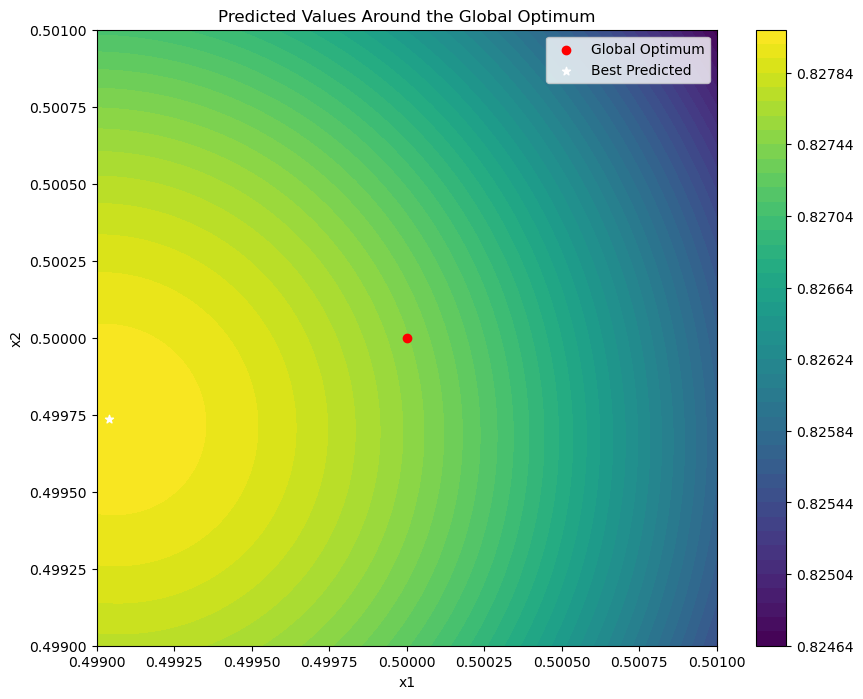

In [43]:
# Global optimum and exploit range
global_optimum = np.array([0.5, 0.5])
exploit_range = 0.001  # Narrow focus, e.g., 5% around the optimum

# Define a high-density search space around the global optimum
x_values = np.linspace(global_optimum[0] - exploit_range, global_optimum[0] + exploit_range, 1000)
y_values = np.linspace(global_optimum[1] - exploit_range, global_optimum[1] + exploit_range, 1000)

# Generate a meshgrid for sampling
X, Y = np.meshgrid(x_values, y_values)
samples = np.vstack([X.ravel(), Y.ravel()]).T

# Use your trained Bayesian regressor to predict the value of each sample
predictions = best_gp.predict(samples)

# Optionally, reshape predictions to match the meshgrid for visualization purposes
prediction_grid = predictions.reshape(X.shape)

# Identify promising points (this step depends on your specific goal)
# For demonstration, let's simply find the sample with the highest predicted value
max_index = np.argmax(predictions)
best_sample = samples[max_index]
best_prediction = predictions[max_index]

print(f"Best sample around the global optimum: {best_sample}")
print(f"Predicted value: {best_prediction}")

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, prediction_grid, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(global_optimum[0], global_optimum[1], color='red', label='Global Optimum')
plt.scatter(best_sample[0], best_sample[1], color='white', marker='*', label='Best Predicted')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Predicted Values Around the Global Optimum')
plt.show()

[Back to top](#Index:) 

<a id='part4'></a>

# End

In [42]:
# Define your data points
w9_predict= np.array([
    [0.496849, 0.499283],
    [0.498449, 0.499517],
    [0.497749, 0.499517],
    [0.498899, 0.495615],
    [0.62139, 0.467539],
    [0.62079, 0.467773],
    [0.62089, 0.467773],
    [0.512256, 0.047486],
    [0.787878, 0.959595],
    [0.499999, 0.49999]
])

predictions = best_gp.predict(w9_predict)

# If you wish to create a DataFrame to view the data points alongside their predictions
df_predictions = pd.DataFrame(w9_predict, columns=['x1', 'x2'])
df_predictions['y'] = predictions

print(df_predictions)

         x1        x2         y
0  0.496849  0.499283  0.824986
1  0.498449  0.499517  0.827812
2  0.497749  0.499517  0.827010
3  0.498899  0.495615  0.817396
4  0.621390  0.467539  0.220048
5  0.620790  0.467773  0.217842
6  0.620890  0.467773  0.218117
7  0.512256  0.047486  0.193729
8  0.787878  0.959595  0.095572
9  0.499999  0.499990  0.827451
